# Find nearest paper
* Load the article metadata and the topics assigned to each article
* Write a function that computes the distance between 2 papers based on the topics

In [1]:
import pandas as pd
import pickle
import os
from sklearn.dummy import DummyClassifier
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = '../data'
MODELS_PATH = '../models'

## Load the article metadata and the topics assigned to each article

Load the article abstracts and metadata for the train/validate/test datasets

In [3]:
def load_df(name):
    return pd.read_csv(os.path.join(DATA_PATH, name), index_col=0, converters={"authors_parsed": lambda x:[entry.strip('[]') for entry in  x.split("], ")]})

train_df = load_df('arxiv_train.csv')
validate_df = load_df('arxiv_validate.csv')
test_df = load_df('arxiv_test.csv')

Load the topics assigned to each article

In [4]:
topics_train_df = pd.read_csv(os.path.join(DATA_PATH, 'topics_train.csv'), index_col=0)
topics_validate_df = pd.read_csv(os.path.join(DATA_PATH, 'topics_validate.csv'), index_col=0)
topics_test_df = pd.read_csv(os.path.join(DATA_PATH, 'topics_test.csv'), index_col=0)

The "labels" in this case are the corresponding authors

In [5]:
labels_train = train_df["submitter"]
labels_validate = validate_df["submitter"]
labels_test = test_df["submitter"]

In [6]:
print(f"The train dataset has {train_df.shape[0]} articles by {len(set(labels_train))} unique correspponding authors")
print(f"The validate dataset has {validate_df.shape[0]} articles by {len(set(labels_validate))} unique correspponding authors")
print(f"The test dataset has {test_df.shape[0]} articles by {len(set(labels_test))} unique correspponding authors")

The train dataset has 35000 articles by 27356 unique correspponding authors
The validate dataset has 17500 articles by 15197 unique correspponding authors
The test dataset has 17500 articles by 15165 unique correspponding authors


## Distance
A function to compute the euclidan distance between 2 papers, based on the topics assigned by the topic model.

In [7]:
import numpy as np

def topic_distance(topics1, topics2):
    """
    topic1, topic2: numpy.ndarray, representing the probability that an article is about a topic. An article can have multiple topics.
    Example:
        0    0.000000
        1    0.000000
        2    0.000000
        3    0.000000
        4    0.000000
        5    0.992668
    topic1 and topic2 must be the same length.
    Topics were assigned to articles in 03_assign_topics
    """
    dist = np.linalg.norm(topics1 - topics2)  # euclidean distance, L2 norm is default
    return dist

### Example 1
Pick up a random article in the validate dataset, find the nearest article in the train dataset

In [8]:
%time

# pick a random paper
rnd_article = topics_validate_df.sample()
# numpy array with topics probabilities for the article
topics1 = np.array(rnd_article.values[0])

print(f"Computing {topics_train_df.shape[0]} distances")
sample_np = topics_train_df.to_numpy()
distances = [topic_distance(topics1, topics2) for topics2 in sample_np]

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 5.96 μs
Computing 35000 distances


In [9]:
original_article = validate_df.iloc[rnd_article.index[0]]
print(f"The original article \"{original_article.title}\" authors are: {original_article.authors}")
closest_article = train_df.iloc[distances.index(min(distances))]
print(f"The closest article \"{closest_article.title}\" authors are: {closest_article.authors}")

The original article "Chern insulating state with double-$Q$ ordering wave vectors at the
  Brillouin zone boundary" authors are: Satoru Hayami
The closest article "Layer-dependent superconductivity in iron-based superconductors" authors are: Ke Meng, Xu Zhang, Boqin Song, Baizhuo Li, Xiangming Kong, Sicheng
  Huang, Xiaofan Yang, Xiaobo Jin, Yiyuan Wu, Jiaying Nie, Guanghan Cao, Shiyan
  Li


### Example 2
* Pick up a random article in the validate dataset (the "original article").
* Find articles by the same authors in the train dataset
* Calculate (A) the distances between the "original article" and the articles by the same authors
* Calculate (B) the distances from the "original article" to all other articles
* Compare A and B, expect A to be smaller.

In [10]:
def pick_random_article(metadata_df, topics_df):
    """
    Pick a random article from dataset (e.g. validate dataset)
    Return its metadata (e.g. from validate_df) and its topics (e.g. from topics_validate_df)

    metadata_df: pandas.DataFrame with article metadata, e.g. validate_df
    topics_df: pandas.DataFrame of article topics, e.g. topics_validate_df
    returns: 
        pandas.core.series.Series: article metadata
        numpy.array: article topic probabilities
    """
    # pick a random paper
    rnd_article = topics_df.sample()
    # numpy array with topics probabilities for the article
    topics = np.array(rnd_article.values[0])
    # get the metadata for the chosen article
    original_article = metadata_df.iloc[rnd_article.index[0]]
    return original_article, topics


def find_articles_same_authors(original_article, metadata_df):
    """
    Find articles by the same author(s) in metadata_df
    original_article: pandas.core.series.Series of article metadata
    metadata_df: pandas.DataFrame with article metadata, e.g. train_df
    returns: list of id in metadata_df
    """
    # list the authors of the chosen article
    authors = original_article['authors_parsed']
    # Find articles by at least one of the same authors in the train dataset 
    articles_found = []
    for author in authors:
        for i, row in metadata_df.iterrows():
            if author in row['authors_parsed']:
                articles_found.append(row['id'])
    return articles_found

def get_topics(metadata_df, topics_df, article_id):
    """
    Get the topics corresponding to an article id ('id' column in metadata dataFrame)
    metadata_df: pandas.DataFrame article metadata, e.g. train_df
    topics_df: pandas.DataFrame of article topics, e.g. topics_train_df
    returns: numpy.array: article topic probabilities
    """
    i = list(metadata_df.id).index(article_id)
    topics = topics_df.loc[i]
    return np.array(topics)


In [11]:
def mean_distances(original_article, topics, metadata_df, topics_df):
    """
    Measure the distance Euclidean distance in the topics space, between the "original_article" and
    articles in in train dataset:
    * articles where the at least one of the authors is the same
    * randomly chosen articles (the number of articles is set by MAX_RND_ARTICLES)
    original_article: pandas.core.series.Series of article metadata
    topics: numpy.array of article topic probabilities
    returns
        mean distance same authors, mean distance rnd articles: float
    """
    # Find articles by the same authors in the train dataset
    articles_found = find_articles_same_authors(original_article, metadata_df)
    if len(articles_found) == 0:
        return None, None
    else:
        # Calculate (A) the distances between the "original article" and the articles by the same authors
        distances_same_authors = []
        for article_id in articles_found:
            topics_same_authors = get_topics(metadata_df, topics_df, article_id)
            distance = topic_distance(topics, topics_same_authors)
            distances_same_authors.append(distance)
        # Calculate (B) the distances from the "original article" to all other articles
        distances_all = [topic_distance(topics, topics2) for topics2 in topics_df.to_numpy()]
    return np.mean(distances_same_authors), np.mean(distances_all)

try it out using the validate dataset

In [12]:
%%time

MAX_ARTICLES = 10
# Compare A and B, expect A to be smaller.
mean_distances_same_authors = []
mean_distances_rnd_articles = []
for _ in range(MAX_ARTICLES):
    # Pick up a random article in the validate dataset (the "original article").
    original_article, topics = pick_random_article(validate_df, topics_validate_df)
    mean_same_authors, mean_rnd = mean_distances(original_article, topics, train_df, topics_train_df)
    if (mean_same_authors and mean_rnd):
        mean_distances_same_authors.append(mean_same_authors)
        mean_distances_rnd_articles.append(mean_rnd)

CPU times: user 21.9 s, sys: 0 ns, total: 21.9 s
Wall time: 21.9 s


Using the test dataset

In [13]:
%%time

MAX_ARTICLES = 1000
# Compare A and B, expect A to be smaller.
mean_distances_same_authors = []
mean_distances_rnd_articles = []
for _ in range(MAX_ARTICLES):
    # Pick up a random article in the test dataset (the "original article").
    original_article, topics = pick_random_article(test_df, topics_test_df)
    mean_same_authors, mean_rnd = mean_distances(original_article, topics, train_df, topics_train_df)
    if (mean_same_authors and mean_rnd):
        mean_distances_same_authors.append(mean_same_authors)
        mean_distances_rnd_articles.append(mean_rnd)

CPU times: user 53min 28s, sys: 4.73 s, total: 53min 33s
Wall time: 53min 36s


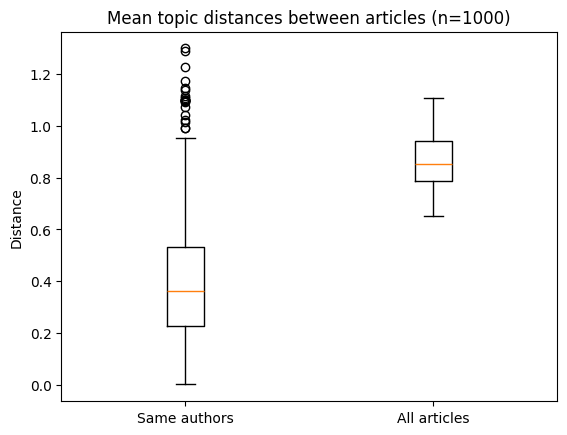

In [14]:
data = [mean_distances_same_authors, mean_distances_rnd_articles]
fig, ax = plt.subplots()
ax.boxplot(data, tick_labels=['Same authors', 'All articles'])
ax.set_ylabel("Distance")
plt.title(f"Mean topic distances between articles (n={MAX_ARTICLES})")
plt.show()

In [15]:
from scipy import stats

# Perform the t-test:
t_stat, p_value = stats.ttest_ind(mean_distances_same_authors, mean_distances_rnd_articles)
print(f"The topic model was trained on {topics_train_df.shape[0]} articles about Physics, submitted in the past 3 years.")
print(f"The test dataset has {topics_test_df.shape[0]} articles. Based on a random sample of {MAX_ARTICLES} articles:")
print(f"The mean distance between articles that share at least one author is {np.mean(mean_distances_same_authors):.2f}.")
print(f"The mean distance between all articles is {np.mean(mean_distances_rnd_articles):.2f}.")
print(f"The p-value is {p_value:.2E}.")


The topic model was trained on 35000 articles about Physics, submitted in the past 3 years.
The test dataset has 17500 articles. Based on a random sample of 1000 articles:
The mean distance between articles that share at least one author is 0.40.
The mean distance between all articles is 0.86.
The p-value is 0.00E+00.
